# Module import

In [4]:
import os
import shutil

import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import timm
# from pytorch_image_models.timm.models.vision_transformer import vit_base_patch8_224  # 추가 작업 필요

# setting

In [5]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


============================ 데이터 전처리를 위한 코드이니 아래 코드는 실행하지 마세요 ============================

# Data preprocessing

## data path

In [10]:
train_path = "/data/badadata/classification/train"
label_path = "/data/badadata/classification/data.csv"

In [11]:
df = pd.read_csv(label_path, index_col=0)
df

,image_path,class
0,44.jpg,1
1,478.jpg,0
2,244.jpg,1
3,161.jpg,1
4,79.jpg,1
...,...,...
663,323.jpg,1
664,555.jpg,0
665,412.jpg,0
666,168.jpg,1


## data split
- 90:10 의 비율로 split 진행 (데이터의 수가 부족한 관계로 train data를 최대한 확보)
    - train : 0 ~ 333.jpg
    - test : 334 ~ 667.jpg


각각 랜덤하게 10% 만큼 추출하여 test directory로 move
- train data : 601개
- test data : 67개

In [12]:
# stratify 인자를 사용하여 label 비율이 동일하도록 설정
train_df, test_df = train_test_split(df, test_size=0.10, stratify=df['class'], random_state=1201)

In [13]:
val_df, test_df = train_test_split(test_df, test_size=0.50, stratify=test_df['class'], random_state=1201)

In [14]:
print(f"length of train data : {len(train_df)}")
print(f"length of val data : {len(val_df)}")
print(f"length of test data : {len(test_df)}")

length of train data : 601
length of val data : 33
length of test data : 34


In [15]:
print("#### train data ####")
print(train_df['class'].value_counts())
print()

print("#### test data ####")
print(val_df['class'].value_counts())
print()

print("#### test data ####")
print(test_df['class'].value_counts())

#### train data ####
0    301
1    300
Name: class, dtype: int64

#### test data ####
1    17
0    16
Name: class, dtype: int64

#### test data ####
0    17
1    17
Name: class, dtype: int64


## generate train & test csv file

In [16]:
train_df.to_csv("/data/badadata/classification/train.csv")
val_df.to_csv("/data/badadata/classification/validation.csv")
test_df.to_csv("/data/badadata/classification/test.csv")

============================ 데이터 전처리를 위한 코드이니 위 코드는 실행하지 마세요 ============================

# Data load

In [34]:
# directory path
main_path = "/project/smcho1201/bada_project/classification"
train_path = "/data/badadata/classification/train"
checkpoint_path = "/data/badadata/classification/checkpoints"

# csv path
train_csv_path = "/data/badadata/classification/train.csv"
val_csv_path = "/data/badadata/classification/validation.csv"
test_csv_path = "/data/badadata/classification/test.csv"

In [18]:
train_df = pd.read_csv(train_csv_path, index_col = 0)
val_df = pd.read_csv(val_csv_path, index_col = 0)
test_df = pd.read_csv(test_csv_path, index_col = 0)

In [19]:
train_df

,image_path,class
649,392.jpg,0
238,605.jpg,0
249,93.jpg,1
264,250.jpg,1
208,303.jpg,1
...,...,...
3,161.jpg,1
258,646.jpg,0
247,396.jpg,0
426,326.jpg,1


In [20]:
val_df

,image_path,class
513,573.jpg,0
573,253.jpg,1
111,49.jpg,1
2,244.jpg,1
108,145.jpg,1
291,288.jpg,1
559,577.jpg,0
666,168.jpg,1
462,123.jpg,1
223,509.jpg,0


In [21]:
test_df

,image_path,class
16,375.jpg,0
329,152.jpg,1
148,631.jpg,0
211,372.jpg,0
346,310.jpg,1
50,131.jpg,1
423,664.jpg,0
640,512.jpg,0
382,550.jpg,0
325,142.jpg,1


# custom datasets

## visualize images (dolphin vs non dolphin)

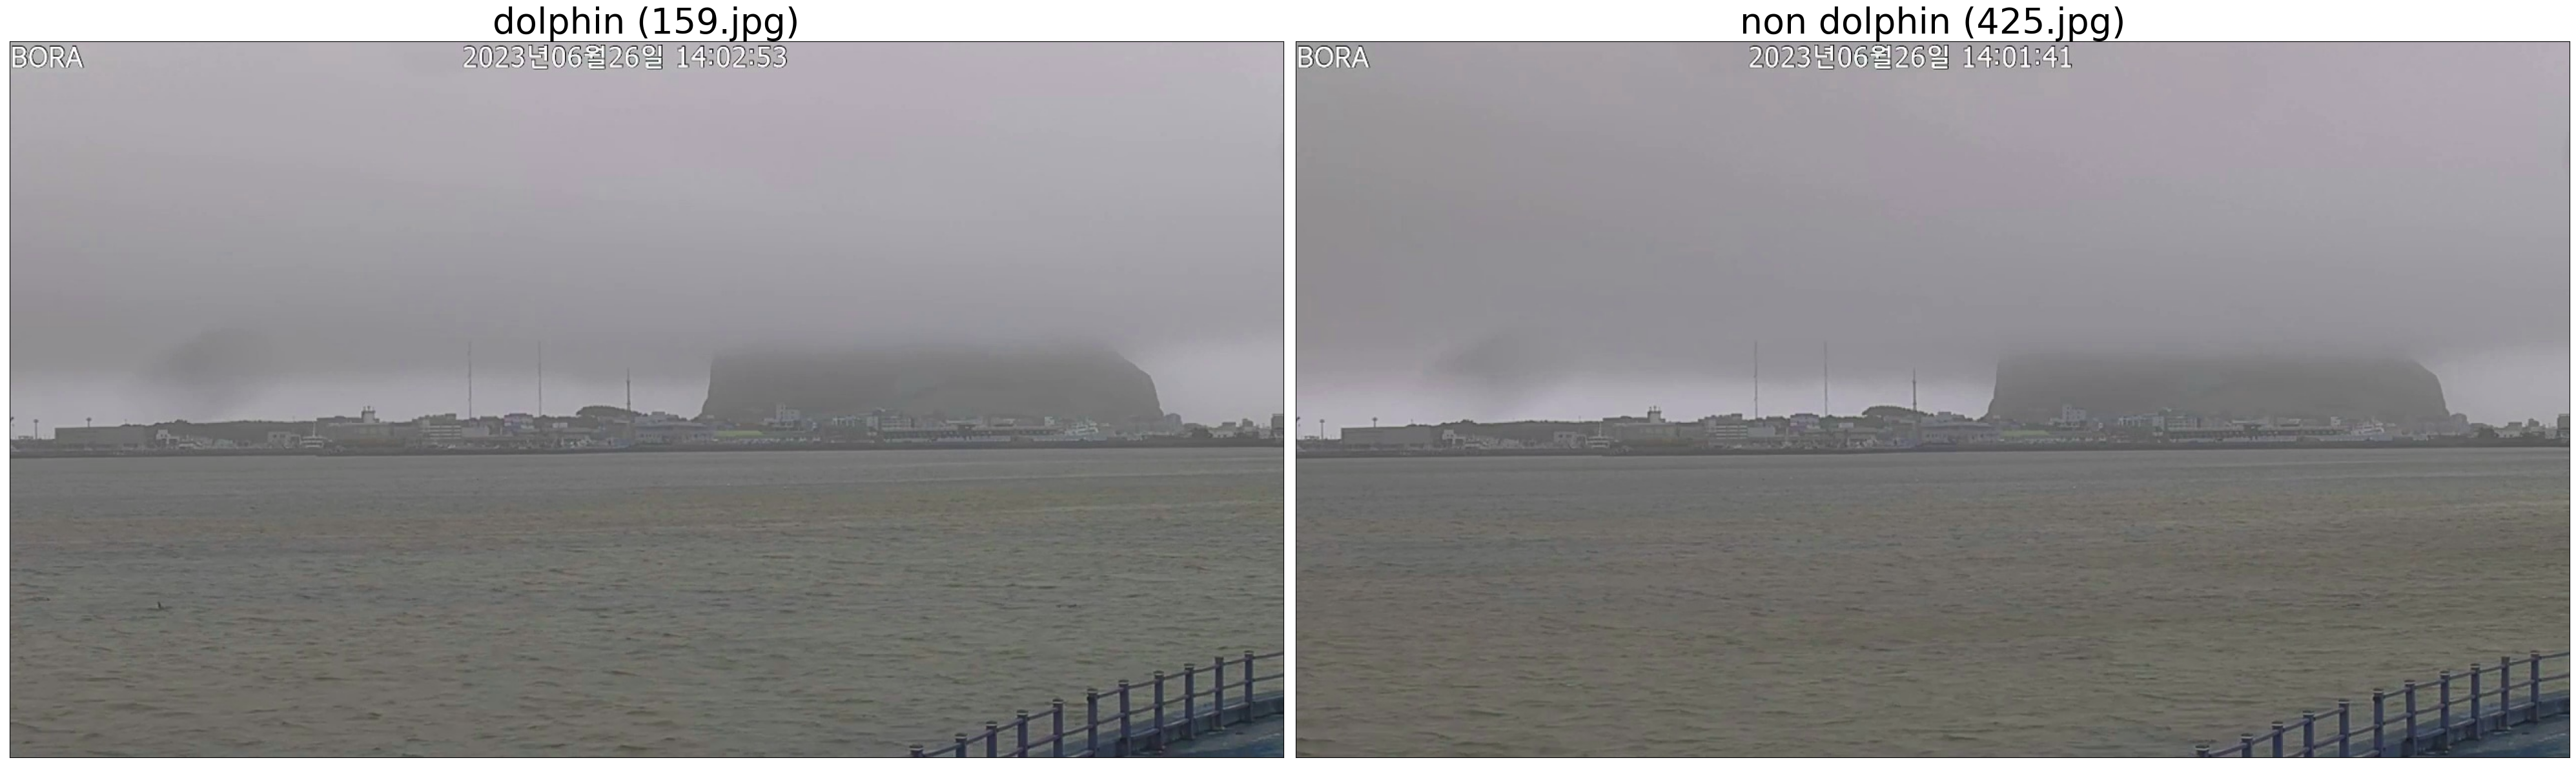

In [22]:
i = random.randint(1, math.floor(len(train_df)/2))

fig, axs = plt.subplots(1,2, figsize = (40,20), dpi = 100)

dolphin_path = train_df.loc[train_df['class'] == 1].iloc[i]['image_path']
non_dolphin_path = train_df.loc[train_df['class'] == 0].iloc[i]['image_path']

dolphin_img = cv2.imread(os.path.join(train_path, dolphin_path))
non_dolphin_img = cv2.imread(os.path.join(train_path, non_dolphin_path))

axs[0].set_title(f"dolphin ({dolphin_path})", fontsize = 40)
axs[0].imshow(dolphin_img)
axs[1].set_title(f"non dolphin ({non_dolphin_path})", fontsize = 40)
axs[1].imshow(non_dolphin_img)

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[1].axes.xaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## custom dataset

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train_path, transform=None):
        self.data = dataframe
        self.transform = transform
        self.train_path = train_path

        self.lst_input = list(self.data['image_path'])
        self.lst_label = list(self.data['class'])

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):

        label = self.lst_label[index]
        img_input = cv2.imread(os.path.join(self.train_path, self.lst_input[0])) # H W C

        if self.transform:
            img_input = self.transform(img_input)

        return img_input, label

## data transform

In [24]:
resize = 224, 224

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(((resize))),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(((resize))),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

## Verify the correct application of the dataset

In [25]:
# 데이터셋 클래스 적용
train_datasets = Dataset(train_df, train_path, transform=transform_train)
print("My custom training-dataset has {} elements".format(len(train_datasets)))

val_datasets = Dataset(val_df, train_path, transform=transform_val)
print("My custom validation-dataset has {} elements".format(len(val_datasets)))

test_datasets = Dataset(test_df, train_path, transform=transform_val)
print("My custom test-dataset has {} elements".format(len(test_datasets)))

My custom training-dataset has 601 elements
My custom validation-dataset has 33 elements
My custom test-dataset has 34 elements


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shape : torch.Size([3, 224, 224]) 
Label : 1


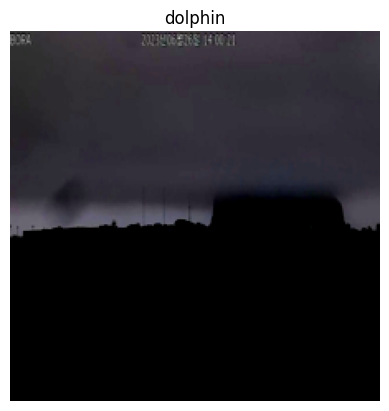

In [26]:
img, label = train_datasets.__getitem__(12)
print(f"Input shape : {img.shape} \nLabel : {label}")

img_np = img.numpy().transpose(1,2,0)

if label == 0:
    name = "non dolphin"
else:
    name = "dolphin"

plt.title(name)
plt.axis('off')
plt.imshow(img_np)

**위 image는 normalize를 한 후 시각화를 한 결과이다. 직관적으로 보았을 때 전체적으로 흑색을 띄며 탐지해야하는 돌고래가 보이지 않음을 확인할 수 있음**
- 단지 직관적으로 본 결과에서만 돌고래 픽셀 값이 사라진 것일 수도 있음. -> 여전히 돌고래의 픽셀 패턴은 존재
- 만약 classification 결과가 좋지 않다면 다른 task로 접근할 필요가 있어보임(**object detection**  &  **image segmentation**)

## Data Loader

In [27]:
BATCH_SIZE = 10

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=BATCH_SIZE, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=BATCH_SIZE, num_workers=2)

# Model Load

In [28]:
def mk_model(model_name, num_classes=2):
    if model_name == 'resnet18':
        from torchvision import models
        import torch

        resnet18_pretrained = models.resnet18(pretrained=True)
        num_ftrs = resnet18_pretrained.fc.in_features
        resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

        resnet18_pretrained.to(DEVICE)

        net = resnet18_pretrained




    if model_name == 'wide_resnet50_2':
        from torchvision import models
        import torch

        wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)

        num_ftr = wide_resnet50_2.fc.in_features
        wide_resnet50_2.fc = nn.Linear(num_ftr, num_classes)

        wide_resnet50_2.to(DEVICE)

        net = wide_resnet50_2




    if model_name == 'EfficientNet_b4':
        from torchvision import models
        import torch
        import timm

        class EfficientNet_b4(nn.Module):
            def __init__(self, num_classes):
                super(EfficientNet_b4, self).__init__()
                self.efficient = timm.create_model(model_name='efficientnet_b4',
                    num_classes=num_classes,
                    pretrained=True
                    )

            def forward(self, x: torch.Tensor) -> torch.Tensor:
                return self.efficient(x)
        EfficientNet_b4 = EfficientNet_b4(50)
        EfficientNet_b4.to(DEVICE)

        net = EfficientNet_b4




    if model_name == 'visformer_small':
        from torchvision import models
        import torch
        import timm

        visformer_small = timm.create_model('visformer_small', num_classes=num_classes, pretrained=True)

        visformer_small.to(DEVICE)

        net = visformer_small




    if model_name == 'vit_small_patch8_224_dino':
        from torchvision import models
        import torch
        import timm

        vit_small_patch8_224_dino = timm.create_model('vit_small_patch8_224_dino', num_classes=num_classes, pretrained=True)

        vit_small_patch8_224_dino.to(DEVICE)

        net = vit_small_patch8_224_dino

    return net

# Early stopping class

In [29]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Train

## train function

In [30]:
def train(model,
          model_name,
          train_dataloader,
          val_dataloader,
          optimizer,
          loss,
          epochs = 30,
          patience = 10,
          early_stopping = False,
          checkpoint_path = checkpoint_path):

    if early_stopping:
        earlystopping = EarlyStopping(patience=10, verbose=True, delta=0, path=f'{os.path.join(checkpoint_path, f"earlystopping_{model_name}.pth")}')

    for epoch in range(1, epochs+1):
        print(f"Train epoch : {epoch}")
        model.train()
        train_loss = 0 # train loss 값
        correct = 0 # 맞힌 개수
        total = 0 # 총 데이터 수

        for batch_idx, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)

            total += labels.size(0)
            current_correct = (predicted == labels).sum().item()
            correct += current_correct

            # batch 가 10단위 일때마다 accuracy, loss 값 출력
            if batch_idx % 10 == 0:
                print('\nCurrent batch:', str(batch_idx))
                print('Current batch average train accuracy:', current_correct / labels.size(0))
                print('Current batch average train loss:', loss.item() / labels.size(0))

        # 훈련이 모두 끝난 후 accuracy, loss 값 출력
        print('\nTotal average train accuarcy:', correct / total)
        print('Total average train loss:', train_loss / total)


        # validation
        print(f"Validation epoch : {epoch}")
        model.eval()
        loss = 0
        correct = 0
        total = 0
        valid_losses = [] # validation loss값을 구하기 위해 각 batch의 loss값 저장

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_dataloader):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                total += labels.size(0)

                outputs = model(inputs)
                loss += criterion(outputs, labels).item()

                valid_losses.append(loss)

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()

            print('\nTotal average test accuarcy:', correct / total)
            print('Total average test loss:', loss / total)

            valid_loss = np.average(valid_losses)

            if early_stopping:
                earlystopping(valid_loss, model)

                if earlystopping.early_stop:
                    print("Early stopping !!")
                    break

    state = {
        'model' : model.state_dict()
    }
    if not os.path.isdir(os.path.join(checkpoint_path, "final")):
        os.mkdir(os.path.join(checkpoint_path, "final"))
    torch.save(state, os.path.join(checkpoint_path, f"final/ckpt_{model_name}.pth"))
    print("Model saved!!")



## training

In [31]:
models = ['resnet18', 'wide_resnet50_2', 'EfficientNet_b4', 'visformer_small', 'vit_small_patch8_224_dino']

for model_name in models:
    model = mk_model(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)
    criterion = nn.CrossEntropyLoss()

    print(f"##### model name : {model_name} #####")

    train(
        model = model,
        model_name = model_name,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        optimizer = optimizer,
        loss = criterion,
        epochs = 100,
        patience = 5,
        early_stopping = True,
        checkpoint_path = checkpoint_path
    )
    print("##### THE END #####\n\n\n\n")

/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### model name : resnet18 #####
Train epoch : 1

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06244997382164001

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06389800310134888

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06796947717666627

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06991295218467712

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.070522940158844

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06542986631393433

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.8551669120788574

Total average train accuarcy: 0.4841930116472546
Total average train loss: 0.07201871856080116
Validation epoch : 1

Total average test accuarcy: 0.


Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.6842081546783447

Total average train accuarcy: 0.5158069883527454
Total average train loss: 0.07089898302630458
Validation epoch : 8

Total average test accuarcy: 0.5151515151515151
Total average test loss: 0.0839894124955842
EarlyStopping counter: 7 out of 10
Train epoch : 9

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.0686980128288269

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06614946126937866

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06770989894866944

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.07081552743911743

Current batch: 40
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06916311979293824

Current batch: 50
Current batch average train accur

/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### model name : wide_resnet50_2 #####
Train epoch : 1

Current batch: 0
Current batch average train accuracy: 0.3
Current batch average train loss: 0.07140347957611085

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06603124737739563

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06773951649665833

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.07011260986328124

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.07110918760299682

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06852694749832153

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.8176987171173096

Total average train accuarcy: 0.5008319467554077
Total average train loss: 0.07184394494864389
Validation epoch : 1

Total average test acc


Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.6430951952934265

Total average train accuarcy: 0.5158069883527454
Total average train loss: 0.07079448011671247
Validation epoch : 8

Total average test accuarcy: 0.5151515151515151
Total average test loss: 0.08359654021985603
EarlyStopping counter: 6 out of 10
Train epoch : 9

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06726552248001098

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.0664532721042633

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06782197952270508

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.07073466181755066

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.06969047784805298

Current batch: 50
Current batch average train accu

##### model name : EfficientNet_b4 #####
Train epoch : 1

Current batch: 0
Current batch average train accuracy: 0.0
Current batch average train loss: 0.3967351198196411

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.07177801132202148

Current batch: 20
Current batch average train accuracy: 0.4
Current batch average train loss: 0.07759498953819274

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.07149156928062439

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.08239110708236694

Current batch: 50
Current batch average train accuracy: 0.3
Current batch average train loss: 0.0724746584892273

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.8410422801971436

Total average train accuarcy: 0.4858569051580699
Total average train loss: 0.0953382867544939
Validation epoch : 1

Total average test accuar


Total average test accuarcy: 0.48484848484848486
Total average test loss: 0.3383002931421453
EarlyStopping counter: 7 out of 10
Train epoch : 9

Current batch: 0
Current batch average train accuracy: 0.3
Current batch average train loss: 0.0754042387008667

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06249034404754639

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06901227235794068

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06958937644958496

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.07079061269760131

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06358567476272584

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.9181314706802368

Total average train accuarcy: 0.49750415973377704
To

##### model name : visformer_small #####
Train epoch : 1

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06894004940986634

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06872895956039429

Current batch: 20
Current batch average train accuracy: 0.4
Current batch average train loss: 0.06955145597457886

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06931568384170532

Current batch: 40
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06931204199790955

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06917631030082702

Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.6858088374137878

Total average train accuarcy: 0.4925124792013311
Total average train loss: 0.07038493997443734
Validation epoch : 1

Total average test acc


Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.680737316608429

Total average train accuarcy: 0.49916805324459235
Total average train loss: 0.07038115205463276
Validation epoch : 8

Total average test accuarcy: 0.5151515151515151
Total average test loss: 0.20574542609128085
EarlyStopping counter: 3 out of 10
Train epoch : 9

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.0687902808189392

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.0685378909111023

Current batch: 20
Current batch average train accuracy: 0.4
Current batch average train loss: 0.06969190239906312

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06932106614112854

Current batch: 40
Current batch average train accuracy: 0.6
Current batch average train loss: 0.0691841721534729

Current batch: 50
Current batch average train accura


Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06932107210159302

Current batch: 40
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06918212175369262

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06894370913505554

Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.680767834186554

Total average train accuarcy: 0.49916805324459235
Total average train loss: 0.07038020363663278
Validation epoch : 16

Total average test accuarcy: 0.5151515151515151
Total average test loss: 0.08384461294520985
EarlyStopping counter: 1 out of 10
Train epoch : 17

Current batch: 0
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06879234313964844

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06854667663574218

Current batch: 20
Current batch average train a


Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06855297088623047

Current batch: 20
Current batch average train accuracy: 0.4
Current batch average train loss: 0.06968549489974976

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.06932108998298644

Current batch: 40
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06917978525161743

Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.0689415991306305

Current batch: 60
Current batch average train accuracy: 1.0
Current batch average train loss: 0.6807901263237

Total average train accuarcy: 0.49916805324459235
Total average train loss: 0.07037934080733238
Validation epoch : 24

Total average test accuarcy: 0.5151515151515151
Total average test loss: 0.08384357799183238
EarlyStopping counter: 9 out of 10
Train epoch : 25

Current batch: 0
Current batch average train accu

/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/timm/models/_factory.py:118: UserWarning: Mapping deprecated model name vit_small_patch8_224_dino to current vit_small_patch8_224.dino.
  **kwargs,


##### model name : vit_small_patch8_224_dino #####
Train epoch : 1

Current batch: 0
Current batch average train accuracy: 0.3
Current batch average train loss: 0.20747690200805663

Current batch: 10
Current batch average train accuracy: 0.3
Current batch average train loss: 0.11510965824127198

Current batch: 20
Current batch average train accuracy: 0.4
Current batch average train loss: 0.07614309787750244

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.07433045506477357

Current batch: 40
Current batch average train accuracy: 0.4
Current batch average train loss: 0.07234135866165162

Current batch: 50
Current batch average train accuracy: 0.3
Current batch average train loss: 0.07905586957931518

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.8857368230819702

Total average train accuarcy: 0.47753743760399336
Total average train loss: 0.11540413835084379
Validation epoch : 1

Total avera


Current batch: 50
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06580712199211121

Current batch: 60
Current batch average train accuracy: 0.0
Current batch average train loss: 0.9290342330932617

Total average train accuarcy: 0.49750415973377704
Total average train loss: 0.07295563326104111
Validation epoch : 8

Total average test accuarcy: 0.48484848484848486
Total average test loss: 0.08459447730671275
EarlyStopping counter: 4 out of 10
Train epoch : 9

Current batch: 0
Current batch average train accuracy: 0.3
Current batch average train loss: 0.07122410535812378

Current batch: 10
Current batch average train accuracy: 0.7
Current batch average train loss: 0.06522318124771118

Current batch: 20
Current batch average train accuracy: 0.6
Current batch average train loss: 0.06762887239456176

Current batch: 30
Current batch average train accuracy: 0.5
Current batch average train loss: 0.0698382556438446

Current batch: 40
Current batch average train ac

# Test

In [32]:
models = ['resnet18', 'wide_resnet50_2', 'EfficientNet_b4', 'visformer_small', 'vit_small_patch8_224_dino']
acc_dict = {}
f1_dict = {}

for model_name in models:
    model = mk_model(model_name)
    state = torch.load(os.path.join(checkpoint_path, f"final/ckpt_{model_name}.pth"))
    model.load_state_dict(state['model'])

    size = (224,224)

    # 예측한 값
    pred_li = []

    for i in range(len(test_df)):
        test_images = list(test_df["image_path"])
        path_img = test_images[i]

        # eval 전 이미지 전처리
        img = cv2.imread(os.path.join(train_path, path_img))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # 양성형 이웃 보간 (2x2 픽셀 참조하여 보간)
        img = cv2.resize(img, size, interpolation = cv2.INTER_LINEAR)

        # eval
        model.eval()
        eval_image = img / 255.0
        eval_image = eval_image.astype(np.float32) # (224, 224, 3)
        eval_image = eval_image.transpose((2,0,1)) # (3, 224, 224)
        eval_image = torch.from_numpy(eval_image).unsqueeze(0) # Batch 채널 추가 (1, 3, 224, 224)
        eval_image = eval_image.to( device=DEVICE, dtype = torch.float32 )

        with torch.no_grad():
            pred = model(eval_image)

        pred = pred.cpu().numpy()
        pred = np.argmax(pred)
        pred_li.append(pred)


    # metric

    y_true = list(test_df['class'])
    y_pred = pred_li
    print("="*40)
    print(f"========== model name : {model_name} ==========")

    f1score = f1_score(y_true, y_pred, average = 'macro')
    f1_dict[model_name] = f1score
    print(f"f1 score (macro) : {f1score}")

    accuracy = accuracy_score(y_true, y_pred)
    acc_dict[model_name] = accuracy
    print(f"Accuracy : {accuracy}")
    print(f"========== THE END of {model_name} ==========")
    print("\n\n\n\n")

========== model name : resnet18 ==========
f1 score (macro) : 0.3333333333333333
Accuracy : 0.5
========== THE END of resnet18 ==========







/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


========== model name : wide_resnet50_2 ==========
f1 score (macro) : 0.3333333333333333
Accuracy : 0.5
========== THE END of wide_resnet50_2 ==========





========== model name : EfficientNet_b4 ==========
f1 score (macro) : 0.17848970251716245
Accuracy : 0.4411764705882353
========== THE END of EfficientNet_b4 ==========





========== model name : visformer_small ==========
f1 score (macro) : 0.3333333333333333
Accuracy : 0.5
========== THE END of visformer_small ==========







/home/smcho1201/.conda/envs/awesompia/lib/python3.7/site-packages/timm/models/_factory.py:118: UserWarning: Mapping deprecated model name vit_small_patch8_224_dino to current vit_small_patch8_224.dino.
  **kwargs,


========== model name : vit_small_patch8_224_dino ==========
f1 score (macro) : 0.3333333333333333
Accuracy : 0.5
========== THE END of vit_small_patch8_224_dino ==========







# THE RESULT

In [35]:
# 딕셔너리를 DataFrame으로 변환
acc_df = pd.DataFrame(list(acc_dict.items()), columns=['Model', 'Accuracy'])
f1_df = pd.DataFrame(list(f1_dict.items()), columns=['Model', 'F1_score'])

# 두 DataFrame을 병합
results_df = pd.merge(acc_df, f1_df, on='Model')
display(results_df)

# 결과를 CSV 파일로 저장
results_df.to_csv(os.path.join(main_path, "classification.csv"), index=False)


,Model,Accuracy,F1_score
0,resnet18,0.500000,0.333333
1,wide_resnet50_2,0.500000,0.333333
2,EfficientNet_b4,0.441176,0.178490
3,visformer_small,0.500000,0.333333
4,vit_small_patch8_224_dino,0.500000,0.333333


예상대로 결과가 좋진 않다. 큰 배경에 작은 object에 대해 분류를 진행했어야 했고 전체적인 feature를 추출해 분류를 진행하는 classification task는 좋은 결과를 얻지 못하였다. 다음으로 시도해볼 수 있는 것은 다음과 같다.
- augmentation
    - 데이터에 돌고래의 80%정도가 나오는 frame만을 추출하여 augmentation을 진행
    - 지느러미만 나오는 frame도 모두 고려를 하다보니 성능적으로 떨어지는 것으로 보임

- object detection
    - 배경과 object가 존재하는 이미지에서 object를 탐지하는 것은 object detection이 적합

- segmentation
    - 픽셀단위로 분류를 진행하기 때문에 작은 픽셀정보만을 담고 있는 object를 탐지하기에 적합할 수 있음